# Mentoria

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import emoji
import io

# detect the laguage of the text in the field mesaage_text
from langdetect import detect, detect_langs
from langdetect.lang_detect_exception import LangDetectException



sns.set(rc={'figure.figsize':(10,6)})
pd.set_option('display.max_rows', 10) # cambiar el número de filas que se mostrarán usando display.max_rows.

In [14]:
src_ds = "data/dataset_diplodatos_completo.csv"
df = pd.read_csv(src_ds)
df.info()

# Original total: 149859

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149859 entries, 0 to 149858
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     149859 non-null  int64  
 1   commodity              119269 non-null  object 
 2   source_posted_at       149859 non-null  object 
 3   trade_type             140916 non-null  object 
 4   chat_id                25857 non-null   float64
 5   telegram_user_id       25857 non-null   float64
 6   message_text           149859 non-null  object 
 7   date_source_posted_at  149859 non-null  object 
 8   message_text_clean     149859 non-null  object 
 9   message_length         149859 non-null  int64  
 10  message_lbr            149859 non-null  int64  
 11  language               149859 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 13.7+ MB


In [15]:
def clean_lbr(text):
    # Replace continuous line breaks with a single line break
    cleaned_text = '\n'.join(line.strip() for line in text.splitlines() if line.strip())
    return cleaned_text

def remove_emojis(text):
    return emoji.replace_emoji(text, '')

def count_line_breaks(text):
    return text.count('\n')

## Limpieza de datos y enriquecimiento
- Sacar los emojis
- Identificar idiomas
    - Adicionar una columna y guardar el dataset
    - Actualizar solo si no existe o se fuerza

- Trim multiple lbrs to ones
- Adicionar message_lbrs
- Adicionar message_length
- Adicionar comodity_in_msg - Pending
- fix date format



In [16]:
if 'message_length' not in df.columns:
    df['date_source_posted_at'] = pd.to_datetime(df['source_posted_at'])

    # Trim and remove multiple line breaks
    df['message_text_clean'] = df['message_text'].apply(clean_lbr)

    # Eliminar emojis y añadir columna message_no_emoji
    df['message_text_clean'] = df['message_text_clean'].apply(remove_emojis).str.strip()

    # Añadir columna con la longitud del mensaje sin emojis
    df['message_length'] = df['message_text_clean'].str.len()

    # Añadir columna con el número de saltos de línea
    df['message_lbr'] = df['message_text_clean'].apply(count_line_breaks)

In [17]:
def detect_language(text):
    try:
        return detect(text)
    except LangDetectException as e:
        print(e, text) 
        return "Unknown"
    else:
        print(e, text)
        return "Error langdetect"

def detect_multiple_languages(text):
    try:
        return detect_langs(text)
    except LangDetectException as e:
        print(e, text) 
        return "Unknown"
    else:
        print(e, text)
        return "Error langdetect"

In [18]:
# df['language_old'] = df['language'] 
# 1.778.822

In [19]:
from pandarallel import pandarallel
pandarallel.initialize()

# df = df.head(10)
if 'language' not in df.columns:
    # df['language'] = df['message_text'].apply(lambda x: detect_language(x) if x is not None else None)
    # df['language'] = df['message_text'].apply(lambda x: detect_language(x) if x is not None else None)
    df['language'] = df['message_text_clean'].parallel_apply(detect_language)
    df.to_csv(src_ds, index=False)

df.head(10)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


,id,commodity,source_posted_at,trade_type,chat_id,telegram_user_id,message_text,date_source_posted_at,message_text_clean,message_length,message_lbr,language
0,2001,DOGE,2022-10-29 17:45:19+00,sell,NaN,NaN,ByBit USDT\n#DOGE/USDT Cancelled ❌\nTarget ach...,2022-10-29 17:45:19+00:00,ByBit USDT\n#DOGE/USDT Cancelled \nTarget achi...,79,2,en
1,45874,REN,2022-01-15 13:01:43+00,buy,NaN,NaN,"ByBit USDT, Binance Futures\n#REN/USDT Entry t...",2022-01-15 13:01:43+00:00,"ByBit USDT, Binance Futures\n#REN/USDT Entry t...",81,2,en
2,49325,ATA,2022-01-14 21:03:16+00,sell,NaN,NaN,Binance Futures\n#ATA/USDT Take-Profit target ...,2022-01-14 21:03:16+00:00,Binance Futures\n#ATA/USDT Take-Profit target ...,93,3,en
3,116487,CLV,2022-08-05 09:32:48+00,sell,NaN,NaN,#CLV here is like a bird out of cage after a l...,2022-08-05 09:32:48+00:00,#CLV here is like a bird out of cage after a l...,114,1,en
4,468132,SOL,2022-04-03 02:20:32+00,buy,25.0,850186.0,TF-V: 5M30S-LLTF-V4\nACCURACY: 91%\nBUY/LONG\n...,2022-04-03 02:20:32+00:00,TF-V: 5M30S-LLTF-V4\nACCURACY: 91%\nBUY/LONG\n...,171,12,en
5,33787,VET,2022-06-14 02:05:13+00,sell,NaN,NaN,"ByBit USDT, Binance Futures\n#VET/USDT All tak...",2022-06-14 02:05:13+00:00,"ByBit USDT, Binance Futures\n#VET/USDT All tak...",117,3,en
6,116491,VITE,2022-08-07 16:36:22+00,buy,NaN,NaN,We are buying #VITE here\n\nVITE is ready for ...,2022-08-07 16:36:22+00:00,We are buying #VITE here\nVITE is ready for a ...,157,2,en
7,51223,DOGE,2022-01-24 18:13:34+00,sell,NaN,NaN,ByBit USDT\n#DOGE/USDT Take-Profit target 2 ✅\...,2022-01-24 18:13:34+00:00,ByBit USDT\n#DOGE/USDT Take-Profit target 2 \n...,88,3,en
8,51225,BAND,2022-01-24 18:14:55+00,sell,NaN,NaN,Binance Futures\n#BAND/USDT Take-Profit target...,2022-01-24 18:14:55+00:00,Binance Futures\n#BAND/USDT Take-Profit target...,93,3,en
9,51226,DYDX,2022-01-24 18:15:47+00,sell,NaN,NaN,"Binance Futures, ByBit USDT\n#DYDX/USDT Take-P...",2022-01-24 18:15:47+00:00,"Binance Futures, ByBit USDT\n#DYDX/USDT Take-P...",104,3,en


In [20]:
# filter df by languages with length > 2
pd.set_option('display.max_rows', 18)
filter = df['language'].str.len() >2
df[filter][['language', 'message_text_clean']]
# configure jupyter to show 18 rows 




,language,message_text_clean
7820,Unknown,https://www.theblockcrypto.com/post/135459/eur...
86223,Unknown,+40%\nhttps://www.tradingview.com/x/epUMlmd4/
97465,Unknown,+36%
120063,Unknown,https://www.theblock.co/post/162913/ethereums-...
123292,Unknown,https://thehiddenwiki.com/new-long-v3-onion-se...
132886,Unknown,𝗣𝗿𝗼𝗳𝗲𝘀𝘀𝗶𝗼𝗻𝗮𝗹 𝗠𝗮𝗿𝗸𝗲𝘁𝗶𝗻𝗴\n𝗣𝗿𝗼𝗺𝗼𝘁𝗲 𝘆𝗼𝘂𝗿 𝗽𝗿𝗼𝗷𝗲𝗰𝘁\n...
135593,Unknown,https://m.economictimes.com/industry/services/...
135973,Unknown,https://www.tradingview.com/chart/BTCUSDT/AcCi...
136095,Unknown,https://www.tradingview.com/chart/ETHUSDT/7pPQ...
136096,Unknown,https://www.tradingview.com/chart/BTCUSDT/BeAf...


In [21]:
# Filter messages in english and Unknown
filter = df['language'].isin(['en', 'Unknown'])
df_filtered = df[filter]
df_filtered.info()



<class 'pandas.core.frame.DataFrame'>
Index: 125830 entries, 0 to 149858
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     125830 non-null  int64  
 1   commodity              105098 non-null  object 
 2   source_posted_at       125830 non-null  object 
 3   trade_type             123512 non-null  object 
 4   chat_id                17889 non-null   float64
 5   telegram_user_id       17889 non-null   float64
 6   message_text           125830 non-null  object 
 7   date_source_posted_at  125830 non-null  object 
 8   message_text_clean     125830 non-null  object 
 9   message_length         125830 non-null  int64  
 10  message_lbr            125830 non-null  int64  
 11  language               125830 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 12.5+ MB


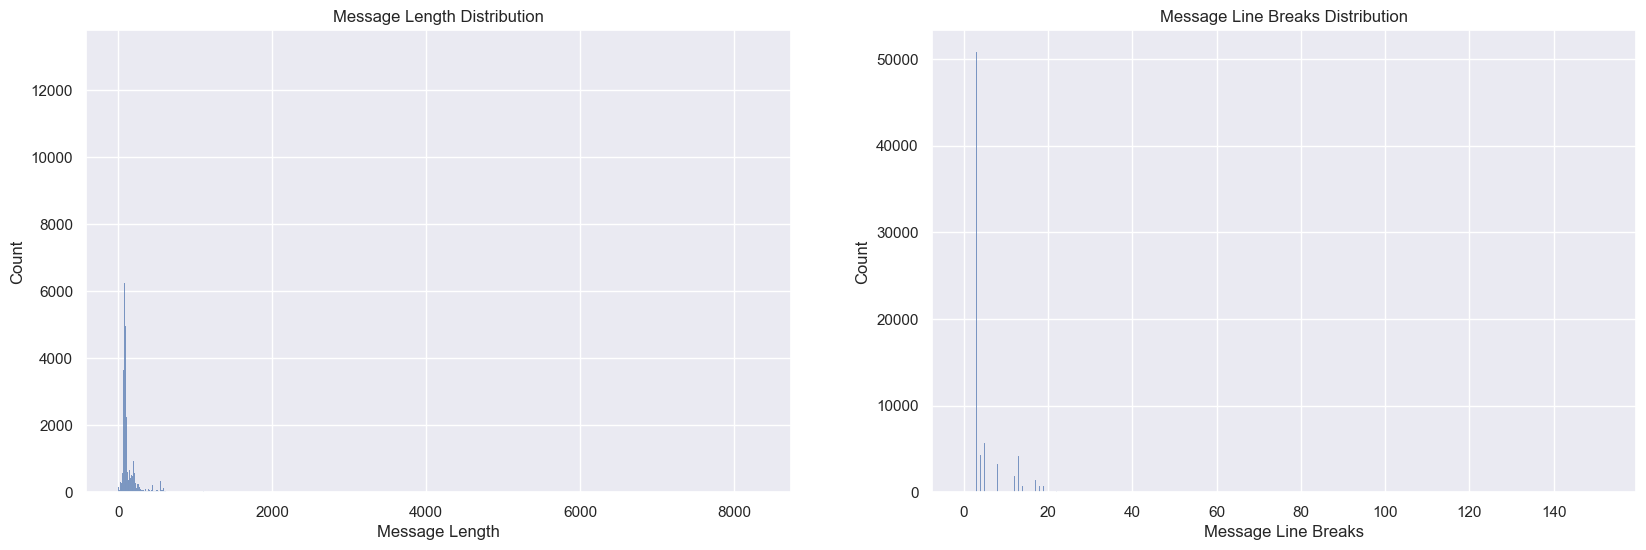

In [22]:
# Generate a distribution plots for message_length and message_lbr
# the plots should one next to the other
# we need to be able to set the size of the plots
# the plots should have a title
# the plots should have labels for the x and y axis

fig, axs = plt.subplots(1, 2, figsize=(20, 6))
sns.histplot(data=df_filtered, x='message_length', ax=axs[0])
axs[0].set_title('Message Length Distribution')
axs[0].set_xlabel('Message Length')
axs[0].set_ylabel('Count')

sns.histplot(data=df_filtered, x='message_lbr', ax=axs[1])
axs[1].set_title('Message Line Breaks Distribution')
axs[1].set_xlabel('Message Line Breaks')
axs[1].set_ylabel('Count')

plt.show()



Hay outlier tanto para message length como para line breaks.
Revisaremos más de cerca los datos con valores abitrarios para hacer un rango más acotado.

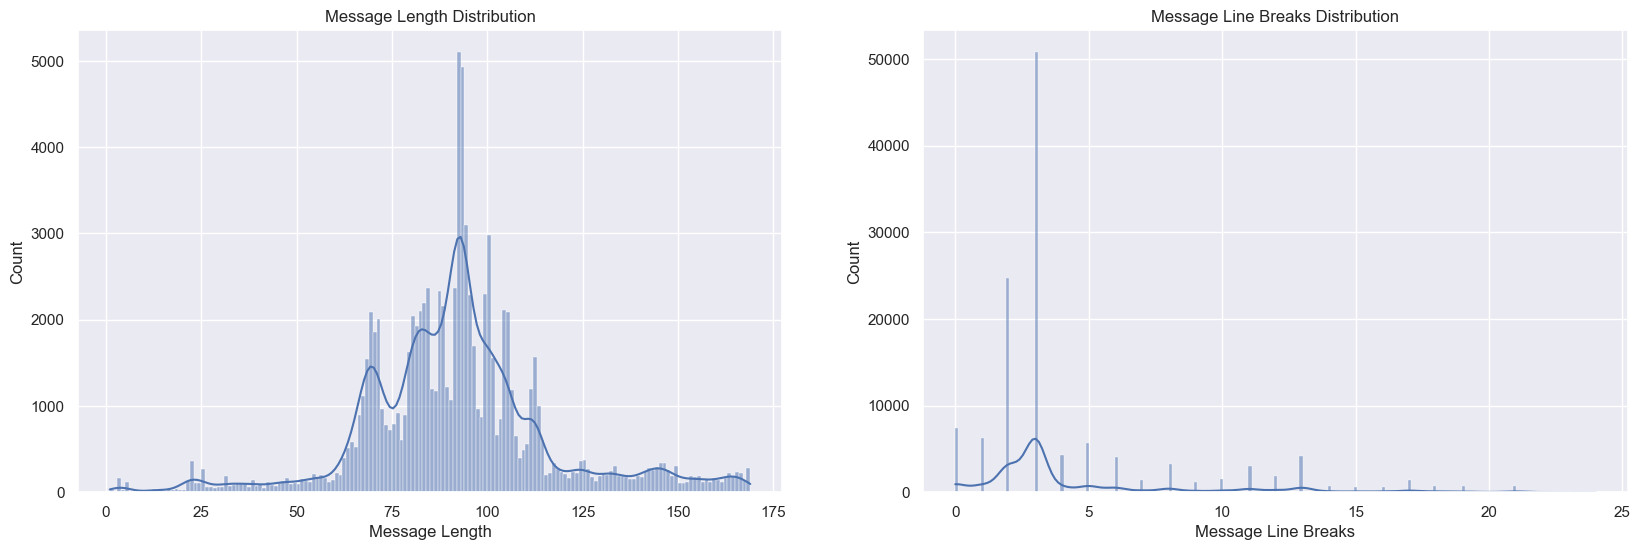

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
flt = df_filtered['message_length'] < 170
sns.histplot(data=df_filtered[flt], x='message_length', ax=axs[0], kde=True)
# sns.histplot(df_filtered[flt]['message_length'], bins=100, kde=True)
axs[0].set_title('Message Length Distribution')
axs[0].set_xlabel('Message Length')
axs[0].set_ylabel('Count')

flt = df_filtered['message_lbr'] < 25
sns.histplot(data=df_filtered[flt], x='message_lbr', ax=axs[1], kde=True)
# sns.histplot(['message_lbr'], bins=100, kde=True)
axs[1].set_title('Message Line Breaks Distribution')
axs[1].set_xlabel('Message Line Breaks')
axs[1].set_ylabel('Count')

plt.show()


Total filtered: 97303, 64.93%


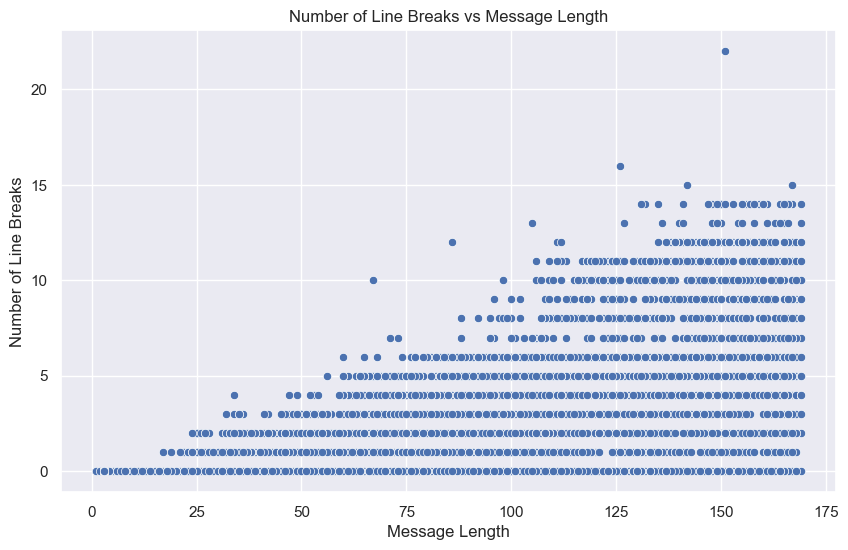

In [24]:
# Generate a distribution plot of the number of line breaks cross message length (scatter plot)
# flt = df['message_length'] < 3170
flt = (df_filtered['message_lbr'] < 25) & (df_filtered['message_length'] < 170)
total_filtered = len(df_filtered[flt])
print(f"Total filtered: {total_filtered}, {total_filtered/len(df):.2%}")

sns.scatterplot(data=df_filtered[flt], x='message_length', y='message_lbr')
plt.xlabel('Message Length')
plt.ylabel('Number of Line Breaks')
plt.title('Number of Line Breaks vs Message Length')
plt.show()


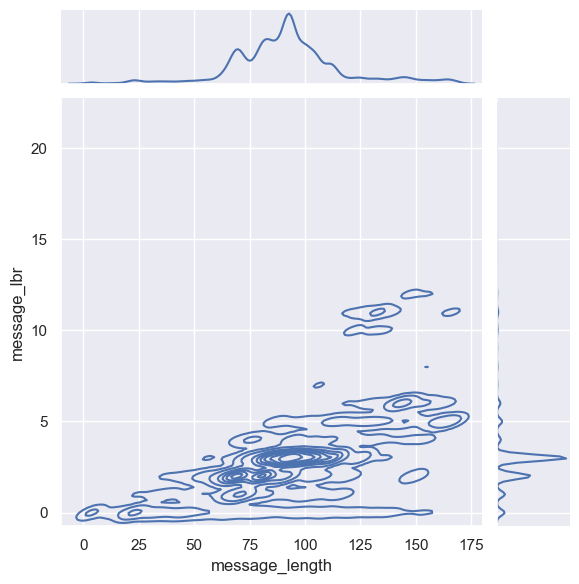

In [25]:
# TODO: Understand KDE plot and how to use it
g = sns.jointplot(data=df_filtered[flt], x='message_length', y='message_lbr', kind='kde')
plt.show()

In [ ]:
# # Look for possible tokes.
# # Export all messages to a text file
# df_filtered['message_text_clean'].to_csv('messages_clean.txt', index=False, header=False)

# generate a new dataframe that has each line of the messages as a row and keep the index of the original message
df_messages = df_filtered['message_text_clean'].str.split('\n').explode().reset_index()

# add a column with the length of each message
df_messages['message_length'] = df_messages['message_text_clean'].str.len()


# split the messages by : and add a column with the first part of the message
flt = df_messages['message_text_clean'].str.contains(':')
df_messages['message_text_clean_split'] = df_messages[flt]['message_text_clean'].str.split(':').str[0].str.strip().str.lower()



In [ ]:
# Get the list of tokens message_text_clean_split and the count as a dataframe
tokens = df_messages['message_text_clean_split'].value_counts()
tokens = tokens.reset_index()
tokens.columns = ['token', 'count']

# filter tokens with count > 2
flt = (tokens['count'] > 50)

print(tokens[flt].describe())

# #print the tokens descending by count
print(tokens[flt])
# # type(tokens)




In [13]:
chat_id = 25.0
chat_df = df[df['chat_id'] == chat_id]
print(len(df), len(chat_df), chat_id)

149859 590 25.0


- Largo de mensje y tiempo
- Exchage?
- Falsos positivos en comodity - Filtrado de datos
- Correlaciones a encontrar
    - Por usr
    - Por mensaje repetido across channels
- Lista de TOKENS - Cuales nos interesan?
- split de mensajes en por tiempo y numero de usuarios
    - tener la lista de users 
- users más activos
- users asociados a monedas

- Por el momento una señal es un mensaje
- Envento - comversación alrededor de una moneda
    - inicio - fin
    - inicio - msg que inicia a  hablar de una moneda
    - fin, silencio por 24 hrs


Clusters 

Similitud de mensajes
Poder decir que canales son similares
Que usuarios son similares
Que usuarios son bots
    Mensajes 

Monedas por canal
Monedas por user
